In [13]:
import xarray as xa
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [71]:
atm_ds = xa.open_dataset('./era5_tryouts/20150201-20150202_snz_tryout_atm.nc')
sfc_ds = xa.open_dataset('./era5_tryouts/20150201-20150202_snz_tryout_sfc.nc')

ml_df = pd.read_csv('./data/model_level.csv',index_col='n')

# -
# create a dataset that contains the ak and bk coefficients of ERA5
# later needed to calculate pressure at each model level from surface pressure
# -
ab_ds = xa.Dataset(
    coords={
        'level'        : era5_ds.level,
      #  'west_east'   : west_east,
      #  'south_north' : south_north
    },
    data_vars={
        'ak'     : (['level'],ml_df.loc[era5_ds.level.values,'a [Pa]'].values),
        'bk'     : (['level'],ml_df.loc[era5_ds.level.values,'b'].values),        
    }
)

xmp_ds = xa.open_dataset('../../Documents/work/uibk/downscaling/NZ south island/ERAI/forcings/southern_nz_6a_icar-095_erai_165,176,-48,-40_31-01-2015-to-01-03-2015.nc')

In [54]:
# if necessary - download metadata about model levels
#ml_df = pd.read_html('https://www.ecmwf.int/en/forecasts/documentation-and-support/137-model-levels')[0]
#ml_df.to_csv('./data/model_level.csv',index=False)

In [72]:
#test whether surface and atmospheric dataset coordinates match

if False in (sfc_ds.time == atm_ds.time).values:
    print(' time dimension not matching')
    
if False in (sfc_ds.longitude == atm_ds.longitude).values:
    print(' longitude not matching')
    
if False in (sfc_ds.latitude == atm_ds.latitude).values:
    print(' latitude not matching')
    
era5_ds = atm_ds.merge(sfc_ds)
era5_ds = era5_ds.merge(ab_ds)

In [45]:
Nt   = len(era5_ds.time)
Nlon = len(era5_ds.longitude)
Nlat = len(era5_ds.latitude)
Nlvl = len(era5_ds.level)

In [ ]:
# concerning ERA5 levels.

# level 0   ... top of the atmosphere (pressure = 0)
# level 137 ... bottom of the atmosphere (surface, pressure = pS)
# in total: 138 model half levels (interfaces between 'full levels')



In [238]:
# first - calculate the pressure at every model level
# set pressure at level 0 (= top of the atmosphere) to nan. this shouldn't be a full level anymore
# and therefor we can't assign a pressure to it.

p           = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)

for n in range(0,Nlvl):
    lvl  = era5_ds.level.values[n]
    ak0  = era5_ds.ak.values[n]        # coef. for half level below (higher pressure)
    bk0  = era5_ds.bk.values[n]
    
    if n > 0:
        ak1  = era5_ds.ak.values[n-1]  # coef. for half level above (lower pressure)
        bk1  = era5_ds.bk.values[n-1]
    else:
        # for n = 0 we have to look up the ak and bk values from
        # the ml_df dataframe since we did not store those in the xarray
        # dataset. we do this only if lvl > 0, otherwise it doesn't matter
        # since the pressure at full-lvl = 0 cannot be specified anyways
        if lvl > 0:
            ak1  = ml_df.loc[lvl-1,'a [Pa]']
            bk1  = ml_df.loc[lvl-1,'b']
        
    
    ps  = era5_ds.sp[:].values
    print('{:4n} {:4n} | {:10.4f} {:10.4f} | {:10.4f} {:10.4f} |'.format(n,lvl,ak0,bk0,ak1,bk1))
    if lvl == 0:
        p[:,n] = ps*np.nan
    else:
        p[:,n] = 0.5*((ak0+bk0*ps)+(ak1+bk1*ps))
    
era5_ds['p'] = (['time','level','latitude','longitude'],p)

   0   30 |  1156.8536     0.0000 |  1037.2012     0.0000 |
   1   31 |  1285.6104     0.0000 |  1156.8536     0.0000 |
   2   32 |  1423.7701     0.0000 |  1285.6104     0.0000 |
   3   33 |  1571.6229     0.0000 |  1423.7701     0.0000 |
   4   34 |  1729.4490     0.0000 |  1571.6229     0.0000 |
   5   35 |  1897.5193     0.0000 |  1729.4490     0.0000 |
   6   36 |  2076.0959     0.0000 |  1897.5193     0.0000 |
   7   37 |  2265.4316     0.0000 |  2076.0959     0.0000 |
   8   38 |  2465.7705     0.0000 |  2265.4316     0.0000 |
   9   39 |  2677.3481     0.0000 |  2465.7705     0.0000 |
  10   40 |  2900.3914     0.0000 |  2677.3481     0.0000 |
  11   41 |  3135.1194     0.0000 |  2900.3914     0.0000 |
  12   42 |  3381.7437     0.0000 |  3135.1194     0.0000 |
  13   43 |  3640.4683     0.0000 |  3381.7437     0.0000 |
  14   44 |  3911.4905     0.0000 |  3640.4683     0.0000 |
  15   45 |  4194.9307     0.0000 |  3911.4905     0.0000 |
  16   46 |  4490.8174     0.0000 |  419

In [7]:
xmp_ds.XLONG[0].shape

(15, 19)

In [201]:
# prepare the arrays
west_east = range(0,Nlon)
south_north = range(0,Nlon)
bottom_top  = (137-era5_ds.level)[::-1]                    # reverse order, 137 is lowest level in ERA5, is here now 0

xlong       = np.zeros(Nt*Nlon*Nlat).reshape(Nt,Nlat,Nlon)
xlat        = np.zeros(Nt*Nlon*Nlat).reshape(Nt,Nlat,Nlon)
Time        = era5_ds.time.values

U           = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)
V           = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)
QVAPOR      = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)
QCLOUD      = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)
QICE        = np.zeros(Nt*Nlvl*Nlon*Nlat).reshape(Nt,Nlvl,Nlat,Nlon)

# set values
U          = era5_ds.u[:,::-1,::-1,:]
V          = era5_ds.v[:,::-1,::-1,:]
P          = era5_ds.p[:,::-1,::-1,:]
QVAPOR     = era5_ds.q[:,::-1,::-1,:]
QCLOUD     = era5_ds.clwc[:,::-1,::-1,:]
QICE       = era5_ds.ciwc[:,::-1,::-1,:]


xlong[:,:] = era5_ds.longitude

for ny in range(Nlat):
    xlat[:,ny,:] = era5_ds.latitude[::-1].values[ny]

In [120]:
frc_ds = xa.Dataset(
    coords={
        'Time'        : Time,
      #  'west_east'   : west_east,
      #  'south_north' : south_north
    },
    data_vars={
        'XLONG'    : (['Time','south_north','west_east'],xlong),
        'XLAT'     : (['Time','south_north','west_east'],xlat),
        'U'        : (['Time','bottom_top','south_north','west_east'],U),
        'V'        : (['Time','bottom_top','south_north','west_east'],V),
        'P'        : (['Time','bottom_top','south_north','west_east'],P),
        'QVAPOR'   : (['Time','bottom_top','south_north','west_east'],QVAPOR),
        'QCLOUD'   : (['Time','bottom_top','south_north','west_east'],QCLOUD),
        'QICE'     : (['Time','bottom_top','south_north','west_east'],QICE)
        
    }
)

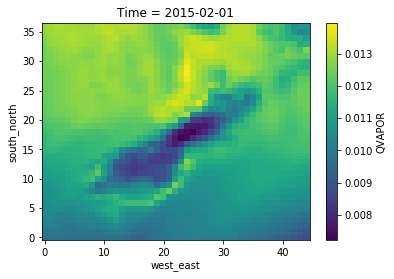

In [121]:
frc_ds.QVAPOR[0,0].plot()

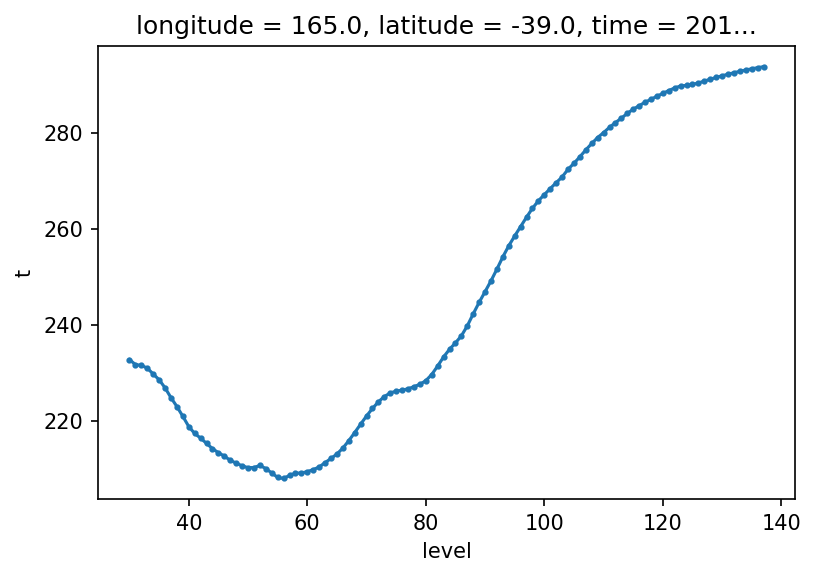

In [203]:
f,ax = plt.subplots(1,1,dpi=150)
era5_ds['t'][0,:,0,0].plot(marker='o',markersize=2)

[]

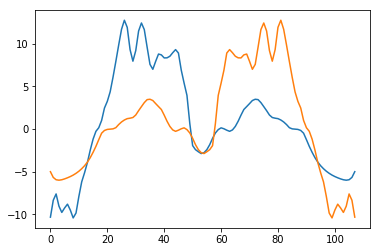

In [123]:
plt.plot(era5_ds.u[0,:,-1,0])
plt.plot(frc_ds.U[0,:,0,0])
plt.plot()

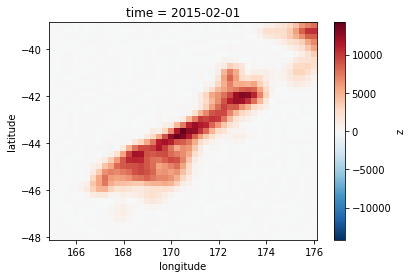

In [51]:
era5_ds.z[0].plot()

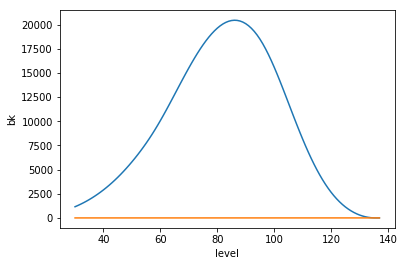

In [70]:
ab_ds.ak.plot()
ab_ds.bk.plot()

In [263]:
xmp_ds.data_vars

Data variables:
    XLONG    (Time, south_north, west_east) float32 ...
    XLAT     (Time, south_north, west_east) float32 ...
    U        (Time, bottom_top, south_north, west_east) float32 ...
    V        (Time, bottom_top, south_north, west_east) float32 ...
    PH       (Time, bottom_top, south_north, west_east) float32 ...
    T        (Time, bottom_top, south_north, west_east) float32 ...
    PB       (Time, bottom_top, south_north, west_east) float32 ...
    P        (Time, bottom_top, south_north, west_east) float32 101191.06 ...
    HGT      (Time, south_north, west_east) float32 ...
    PHB      (Time, bottom_top, south_north, west_east) float32 ...
    QVAPOR   (Time, bottom_top, south_north, west_east) float32 ...
    QCLOUD   (Time, bottom_top, south_north, west_east) float32 ...
    QICE     (Time, bottom_top, south_north, west_east) float32 ...
    TSK      (Time, bottom_top, south_north, west_east) float32 ...
    sp       (Time, south_north, west_east) float32 ...

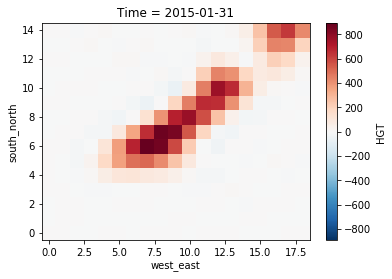

In [264]:
xmp_ds.HGT[0,:].plot()

In [265]:
xmp_ds

<xarray.Dataset>
Dimensions:  (Time: 124, bottom_top: 60, south_north: 15, west_east: 19)
Coordinates:
  * Time     (Time) datetime64[ns] 2015-01-31 2015-01-31T06:00:00 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    XLONG    (Time, south_north, west_east) float32 ...
    XLAT     (Time, south_north, west_east) float32 ...
    U        (Time, bottom_top, south_north, west_east) float32 ...
    V        (Time, bottom_top, south_north, west_east) float32 ...
    PH       (Time, bottom_top, south_north, west_east) float32 ...
    T        (Time, bottom_top, south_north, west_east) float32 ...
    PB       (Time, bottom_top, south_north, west_east) float32 ...
    P        (Time, bottom_top, south_north, west_east) float32 101191.06 ...
    HGT      (Time, south_north, west_east) float32 ...
    PHB      (Time, bottom_top, south_north, west_east) float32 ...
    QVAPOR   (Time, bottom_top, south_north, west_east) float32 ...
    QCLOUD   (Time, bo

In [267]:
era5_ds.q

<xarray.DataArray 'q' (time: 48, level: 108, latitude: 37, longitude: 45)>
[8631360 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 165.0 165.25 165.5 165.75 166.0 166.25 ...
  * latitude   (latitude) float32 -39.0 -39.25 -39.5 -39.75 -40.0 -40.25 ...
  * level      (level) int32 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 ...
  * time       (time) datetime64[ns] 2015-02-01 2015-02-01T01:00:00 ...
Attributes:
    units:          kg kg**-1
    long_name:      Specific humidity
    standard_name:  specific_humidity

# calculating geopotential at each model level

https://www.ecmwf.int/sites/default/files/elibrary/2015/9210-part-iii-dynamics-and-numerical-procedures.pdf

also saved to literature/ifs

In [281]:
# --
# some gas constants
# source: http://glossary.ametsoc.org/wiki/Gas_constant
# --

R_D = 287.06    # dry air,     J K**-1 kg**-1
R_V = 461       # water vapor, J K**-1 kg**-1

lvlmax = 137

# ----------------------------------------------
# calculates geopotential at half layer k+1/2
# ----------------------------------------------
# (k+1/2 lies below full layer k)
# 
# level 0.5 corresponds to the top of the atmosphere
# level 137.5 to the surface
# full levels range from 1 to 137
#
# k      full level below which to calculate phi_(k+1/2) (half layer k+1/2)
# phis   geopotential at surface
# ps     surface pressure
# 
def phikhalf(phis,k):
    
    s = 0
    
    sp = era5_ds.sp.values
    
    for j in range(k+1,lvlmax):    
        au = ml_df.loc[j,'a [Pa]']
        bu = ml_df.loc[j,'b']

        al = ml_df.loc[j+1,'a [Pa]']
        bl = ml_df.loc[j+1,'b']

        pu = au+bu*sp
        pl = al+bl*sp
        
        t  = era5_ds.sel(level=j)['t']
        q  = era5_ds.sel(level=j)['q']
        tv = t*(1+(R_V/R_D-1.0)*q)       
        
        s+=R_D*tv*np.log(pl/pu)
        
    return s

In [282]:
phikhalf(0,40)

<xarray.DataArray (time: 48, latitude: 37, longitude: 45)>
array([[[230927.28, 230916.73, ..., 223955.42, 223277.66],
        [230945.47, 230940.64, ..., 220855.12, 220769.78],
        ...,
        [231673.98, 231677.6 , ..., 231615.33, 231606.55],
        [231685.66, 231681.81, ..., 231630.36, 231619.77]],

       [[230926.72, 230914.7 , ..., 223895.75, 223222.22],
        [230935.77, 230927.97, ..., 220797.86, 220716.67],
        ...,
        [231693.06, 231700.52, ..., 231629.19, 231623.25],
        [231706.92, 231703.42, ..., 231646.11, 231639.62]],

       ...,

       [[231062.12, 231055.83, ..., 224171.03, 223510.16],
        [231076.78, 231072.69, ..., 221050.75, 220972.1 ],
        ...,
        [231461.27, 231467.5 , ..., 231646.19, 231638.69],
        [231464.7 , 231463.62, ..., 231648.94, 231640.58]],

       [[231038.86, 231033.02, ..., 224117.6 , 223453.75],
        [231044.47, 231041.06, ..., 220977.11, 220894.27],
        ...,
        [231520.02, 231523.08, ..., 231603.2

In [276]:
era5_ds.sel(level=37)['q']

<xarray.DataArray 'q' (time: 48, latitude: 37, longitude: 45)>
array([[[3.016088e-06, 3.016088e-06, ..., 3.016088e-06, 3.016088e-06],
        [3.016088e-06, 3.016088e-06, ..., 3.016088e-06, 3.016088e-06],
        ...,
        [3.016088e-06, 3.016088e-06, ..., 3.016088e-06, 3.016088e-06],
        [3.016088e-06, 3.016088e-06, ..., 3.016088e-06, 3.016088e-06]],

       [[3.016088e-06, 3.016088e-06, ..., 3.016088e-06, 3.016088e-06],
        [3.016088e-06, 3.016088e-06, ..., 3.016088e-06, 3.016088e-06],
        ...,
        [3.016088e-06, 3.016088e-06, ..., 3.016088e-06, 3.016088e-06],
        [3.016088e-06, 3.016088e-06, ..., 3.016088e-06, 3.016088e-06]],

       ...,

       [[2.784654e-06, 2.784654e-06, ..., 2.784654e-06, 2.784654e-06],
        [2.784654e-06, 2.784654e-06, ..., 2.784654e-06, 2.784654e-06],
        ...,
        [3.016088e-06, 3.016088e-06, ..., 3.016088e-06, 3.016088e-06],
        [3.016088e-06, 3.016088e-06, ..., 3.016088e-06, 3.016088e-06]],

       [[2.784654e-06, 2.78

In [272]:
era5_ds.sp[:]

<xarray.DataArray 'sp' (time: 48, latitude: 37, longitude: 45)>
array([[[100574.88 , 100592.85 , ...,  93256.76 ,  92442.76 ],
        [100536.77 , 100562.91 , ...,  89657.72 ,  89600.82 ],
        ...,
        [100298.83 , 100326.875, ..., 101057.84 , 101083.7  ],
        [100314.89 , 100329.87 , ..., 101058.93 , 101082.89 ]],

       [[100526.42 , 100544.39 , ...,  93180.53 ,  92365.44 ],
        [100492.4  , 100516.35 , ...,  89584.49 ,  89527.32 ],
        ...,
        [100283.31 , 100311.35 , ..., 101012.375, 101033.34 ],
        [100299.375, 100309.45 , ..., 101007.48 , 101027.35 ]],

       ...,

       [[101318.1  , 101300.14 , ...,  92470.25 ,  91610.24 ],
        [101287.07 , 101270.19 , ...,  88875.3  ,  88721.21 ],
        ...,
        [100392.21 , 100383.23 , ...,  99041.08 ,  98987.17 ],
        [100341.305, 100323.06 , ...,  98999.15 ,  98941.164]],

       [[101303.13 , 101282.17 , ...,  92438.125,  91572.125],
        [101277.   , 101257.94 , ...,  88849.164,  88692.08